In [1]:
import numpyro
numpyro.set_host_device_count(4)

import numpy as np
from scipy.stats import norm
from tqdm import trange

from jax import numpy as jnp
from jax import random
from numpyro import plate, sample, factor
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_median


import matplotlib.pyplot as plt
%matplotlib inline

SPEED_OF_LIGHT = 299792.458


def r2mu(r):
    return 5 * jnp.log10(r) + 25

def mu2r(mu):
    return 10**((mu - 25) / 5)

def r2czcosmo(r, H0=70):
    return r * H0

Retained 43 out of 500 points.


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_9551/506543769.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


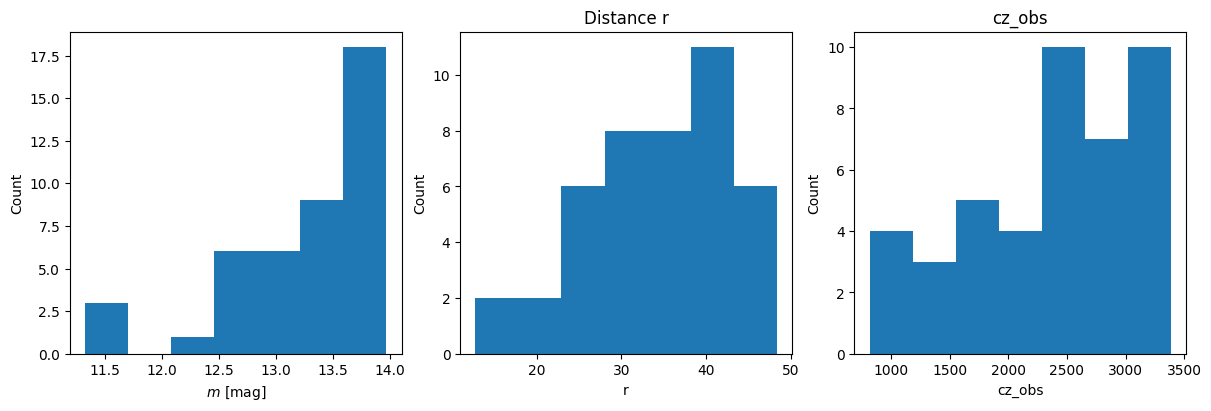

In [2]:
npoints = 500

Rmax = 100
M = -19.25
sigma_v = 250
e_mag = 0.15
H0 = 70
mag_lim = 14.0
cz_lim = None


def generate_mock(seed, mag_lim=None, cz_lim=None, verbose=False,
                  make_plot=False):
    gen = np.random.default_rng(seed)

    r = Rmax * gen.uniform(0, 1, npoints)**(1/3)
    mag = gen.normal(r2mu(r) + M, e_mag, )
    cz = gen.normal(r2czcosmo(r, H0=H0), sigma_v)

    mask = np.ones_like(mag, dtype=bool)
    if mag_lim is not None:
        mask &= mag < mag_lim
    if cz_lim is not None:
        mask &= cz < cz_lim
    
    if verbose:
        print(f"Retained {np.sum(mask)} out of {npoints} points.")

    mag, cz, r = mag[mask], cz[mask], r[mask]

    if make_plot:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
        axes[0].hist(mag, bins="auto")
        axes[0].set_xlabel(r"$m ~ [\mathrm{mag}]$")
        axes[0].set_ylabel('Count')

        axes[1].hist(r, bins="auto")
        axes[1].set_title(r'Distance r')
        axes[1].set_xlabel('r')
        axes[1].set_ylabel('Count')

        axes[2].hist(cz, bins="auto")
        axes[2].set_title('cz_obs')
        axes[2].set_xlabel('cz_obs')
        axes[2].set_ylabel('Count')

        fig.show()

    return mag, cz, r
    


__ = generate_mock(1, mag_lim, cz_lim, verbose=True, make_plot=True)

In [3]:
class FluxSelectionModel:

    def __init__(self, mag_lim, e_mag, Rmax_survey, sigma_v, H0):
        self.mag_lim = mag_lim
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.sigma_v = sigma_v
        self.H0 = H0

    def __call__(self, mag_obs, cz_obs):
        N = len(mag_obs)

        M = sample('M', Normal(-19.25, 1.0))
        factor("global_norm", N * 0.6 * jnp.log(10) * M)

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))
            factor("log_r", 2 * jnp.log(r))

            mu_r = 5 * jnp.log10(r) + 25
            m_mean = mu_r + M
            cz = r2czcosmo(r, H0=self.H0)

        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(m_mean, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(cz, sigma_v), obs=cz_obs)


class RedshiftSelectionModel:

    def __init__(self, cz_lim, e_mag, Rmax_survey, sigma_v, M):
        self.cz_lim = cz_lim
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.sigma_v = sigma_v
        self.M = M

    def __call__(self, mag_obs, cz_obs):
        N = len(mag_obs)

        H0 = sample('H0', Uniform(1, 100))
        factor("global_norm", 3 * N * jnp.log(H0))

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))
            factor("log_r", 2 * jnp.log(r))

            mu_r = 5 * jnp.log10(r) + 25
            m_mean = mu_r + self.M
            cz = r2czcosmo(r, H0=H0)

        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(m_mean, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(cz, sigma_v), obs=cz_obs)

In [ ]:
num_warmup = 500
num_steps = 1000


# NOTE: Make sure to switch the mock generator to be generating magnitude limited mocks!

# model = RedshiftSelectionModel(cz_lim=cz_lim, e_mag=e_mag, Rmax_survey=Rmax, sigma_v=sigma_v, M=M)
# param_bias_test = "H0"

model = FluxSelectionModel(mag_lim=mag_lim, e_mag=e_mag, Rmax_survey=Rmax, sigma_v=sigma_v, H0=H0)
param_bias_test = "M"

nrepeat = 100
progress_bar = nrepeat == 1

bias = []

for i in trange(nrepeat, desc="Running MCMC", disable=progress_bar):
    mag, cz, r = generate_mock(500 + i, mag_lim=mag_lim, cz_lim=cz_lim)

    kernel = NUTS(model, init_strategy=init_to_median(num_samples=2500))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_steps, num_chains=4, progress_bar=progress_bar)
    mcmc.run(
        random.PRNGKey(i),
        mag_obs=jnp.asarray(mag),
        cz_obs=jnp.asarray(cz),
        )

    samples = mcmc.get_samples()
    if progress_bar:
        mcmc.print_summary()
    
    param = param_bias_test
    if param == "M":
        x0 = M
    elif param == "H0":
        x0 = H0
    else:
        raise ValueError("Unknown parameter: {}".format(param))

    bias.append((jnp.mean(samples[param]) - x0) / jnp.std(samples[param]))

bias = jnp.asarray(bias)

Running MCMC: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


### Parameter bias test

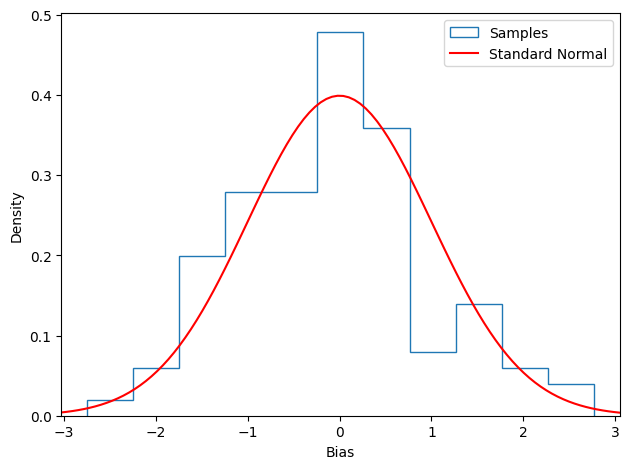

In [7]:
plt.figure()

plt.hist(bias, bins="auto", density=True, label="Samples", histtype="step")

xlim = plt.xlim()
xrange = np.linspace(*xlim, 100)
plt.plot(xrange, norm.pdf(xrange), label="Standard Normal", color='red')
plt.xlim(*xlim)

plt.xlabel("Bias")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
plt.hist(np.mean(samples["r"], axis=0), bins="auto", density=True, label="Samples", histtype="step")
plt.hist(r, bins="auto", density=True, label="True", histtype="step")

plt.legend()


plt.show()


In [ ]:
dx = (np.mean(samples["r"], axis=0) - r) / np.std(samples["r"], axis=0)
plt.figure()
plt.hist(dx, bins="auto", density=True, label="Samples", histtype="step")

xlim = plt.xlim()
xrange = np.linspace(*xlim, 100)
plt.plot(xrange, norm.pdf(xrange), label="Standard Normal", color='red')
plt.xlim(*xlim)

plt.show()